<a href="https://colab.research.google.com/github/sergiorolnic/datascience/blob/main/datascience_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Box Office Prediction
**Programmazione di Applicazioni Data Intensive**

Ingegneria e Scienze Informatiche 2021

Sergiu Gabriel Rolnic

Il seguente progetto riguarda l'analisi  dei dati raccolti dal sito [The Movie Database](https://www.themoviedb.org/). Lo scopo finale sarà quello di prevedere gli incassi di un film avendo a disposizione solo dati esistenti prima della effettiva uscita nelle sale.


# **Esplorazione Dati**

Importazione del dataset e delle librerie utili per la sua analisi

In [ ]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [156]:
if not os.path.exists("train.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/sergiorolnic/datascience/main/train.csv", "train.csv")

data = pd.read_csv("train.csv")    

In [157]:
data.shape

(3000, 23)

In [161]:
data.head(1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651


In [162]:
data.tail(1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
3000,NaN,35000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",http://www.abductionthefilm.com/,tt1600195,en,Abduction,A young man sets out to uncover the truth abou...,10.512109,/cUT6NQP5LAJpmUoStGtXmvNt4zA.jpg,"[{'name': 'Lions Gate Films', 'id': 35}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",9/22/11,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They stole his life. He's taking it back.,Abduction,"[{'id': 591, 'name': 'cia'}, {'id': 822, 'name...","[{'cast_id': 2, 'character': 'Nathan Harper', ...","[{'credit_id': '5391990d0e0a260fb5001629', 'de...",82087155


Notiamo la presenza di feature particolari: dizionari con una o piu' entrate, valori numerici su scale diverse, stringhe di varia natura. La challenge principale sarà quella di riuscire ad estrarre delle informazione utili da piu' variabili possibili.   

La colonna "id" può essere usata come indice del nostro dataframe

In [160]:
data = pd.read_csv("train.csv", index_col=0)  

In [163]:
data.head(1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651


## Significato delle colonne



*   *belongs_to_collection*: appartenenza ad una serie cinematografica
*   *budget*: costo di produzione
*   *genres*: generi
*   *homepage*: link al sito web


*   *imdb_id*: id imbd

*   *original_language*: lingua originale

*   *original_title*: titolo originale

*   *overview*: plot
*   *popularity*: popolarità
*   *poster_path*: path della locandina ufficiale
*   *production_companies*: compagnia di produzione
*   *production_countries*: paese di produzione
*   *release_date*: data di uscita
*   *runtime*: durata
*   *spoken_languages*: lingua del film
*   *status*: stato del rilascio
*   *tagline*: slogan film
*   *title*: titolo
*   *Keywords*: parole chiavi
*   *cast*: cast
*   *crew*: trop
*   *revenue*: incasso del film --> variabile da predire

In [84]:
train_data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  604 non-null    object 
 1   budget                 3000 non-null   float64
 2   genres                 2993 non-null   object 
 3   homepage               946 non-null    object 
 4   imdb_id                3000 non-null   object 
 5   original_language      3000 non-null   object 
 6   original_title         3000 non-null   object 
 7   overview               2992 non-null   object 
 8   popularity             3000 non-null   float64
 9   poster_path            2999 non-null   object 
 10  production_companies   2844 non-null   object 
 11  production_countries   2945 non-null   object 
 12  release_date           3000 non-null   object 
 13  runtime                2998 non-null   float64
 14  spoken_languages       2980 non-null   object 
 15  stat

In [85]:
train_data.isnull().sum()

belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

Analizziamo le features individualmente ed eventualmente evidenziamo eventuali rapporti tra esse o con la target feature

 Notiamo subito che **Belongs_to_collection** e **Homepage** presentano una preponderanza di valori null. Si decide perciò di binarizzarle attraverso il quesito "Is Present" in quanto sono features che potrebbero risultare particolarmente utili durante l'addestramento.

In [86]:
train_data['belongs_to_a_collection'] = train_data['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1)
train_data = train_data.drop(columns='belongs_to_collection')

train_data['homepage_is_present'] = train_data['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)
train_data = train_data.drop(columns='homepage')



**Budget**

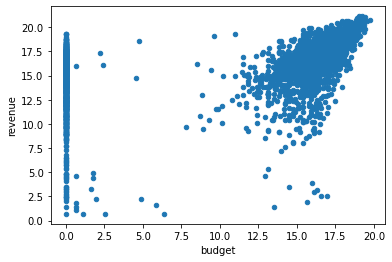

In [87]:
train_data.plot.scatter("budget", "revenue");

Si passano entrambe le features alla funzione logaritmica (log(1+x)) per meglio evidenziare il rapporto di dipendenza tra le due.



In [87]:
train_data.budget = np.log1p(train_data.budget)
train_data.revenue = np.log1p(train_data.revenue)

train_data.plot.scatter("budget", "revenue");

In [88]:

train_data = train_data[train_data.budget > 1]

In [89]:
train_data

,budget,genres,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,belongs_to_a_collection,homepage_is_present
id,,,,,,,,,,,,,,,,,,,,,,
1,16.454568,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",16.326300,1,0
2,17.504390,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",18.370959,1,0
3,15.009433,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",16.387512,0,1
4,13.997833,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16.588099,0,1
6,15.894952,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,/6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg,NaN,NaN,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",14.997740,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993,13.942720,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",tt0015400,en,The Thief of Bagdad,A recalcitrant thief vies with a duplicitous M...,3.878515,/a6IzXkwZRDimfn8HATzP6Pi6Ois.jpg,"[{'name': 'Douglas Fairbanks Pictures', 'id': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",3/18/24,149.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,"""Happiness Must Be Earned""",The Thief of Bagdad,"[{'id': 255, 'name': 'male nudity'}, {'id': 14...","[{'cast_id': 3, 'character': 'The Thief of Bag...","[{'credit_id': '52fe45bec3a368484e06c70b', 'de...",14.009333,0,0
2994,17.909855,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0362227,en,The Terminal,Viktor Navorski is a man without a country; hi...,14.092373,/f4Dup6awDfDqAHKgWqNJ2HFw1qN.jpg,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",6/17/04,128.0,"[{'iso_639_1': 'bg', 'na

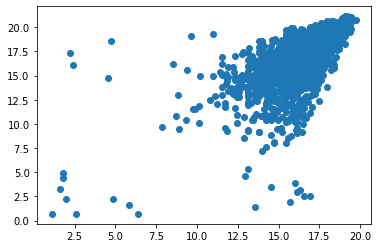

In [90]:

plt.scatter(train_data.budget, train_data.revenue)

Usando la correlazione di Pearson si ottiene una correlazione modesta tra le due variabili

**Genres**

In [91]:
train_data["genres"] = (train_data['genres'].apply(lambda x: [i['name'] for i in eval(x)] if str(x) != 'nan' else []).values)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [92]:
list_of_genres = {i for x in train_data.genres for i in x}

In [93]:
for genre in list_of_genres:
  train_data["genre_" + genre] = train_data['genres'].apply(lambda x: 1 if genre in x else 0)
train_data.drop(columns='genres',inplace=True)  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Per quanto riguara le features **imdb_id, 'original_title', 'status', 'poster_path'** e **title** di eliminarle in quanto poco significative

In [94]:
train_data.head(1)

,budget,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue,belongs_to_a_collection,homepage_is_present,genre_Thriller,genre_History,genre_Science Fiction,genre_Drama,genre_Mystery,genre_Western,genre_Action,genre_Music,genre_Animation,genre_Documentary,genre_Family,genre_Adventure,genre_Crime,genre_War,genre_Romance,genre_Horror,genre_Foreign,genre_Fantasy,genre_TV Movie,genre_Comedy
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,16.454568,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",16.3263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [95]:
train_data.drop(columns=['imdb_id','original_title','status','poster_path', 'title'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [96]:
train_data.dtypes

budget                     float64
original_language           object
overview                    object
popularity                 float64
production_companies        object
production_countries        object
release_date                object
runtime                    float64
spoken_languages            object
tagline                     object
Keywords                    object
cast                        object
crew                        object
revenue                    float64
belongs_to_a_collection      int64
homepage_is_present          int64
genre_Thriller               int64
genre_History                int64
genre_Science Fiction        int64
genre_Drama                  int64
genre_Mystery                int64
genre_Western                int64
genre_Action                 int64
genre_Music                  int64
genre_Animation              int64
genre_Documentary            int64
genre_Family                 int64
genre_Adventure              int64
genre_Crime         

**Original_language**



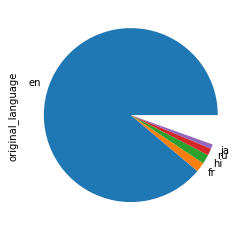

In [97]:
train_data.original_language.value_counts(normalize=True).head(5).plot.pie()


Per quanto a primo impatto potesse risultare un dato interessante, la maggior parte dei film sono in inglese, quindi risulterebbero inutili in fase di addestramento. Lo stesso ragionamento vale per **spoken_language**
Un discorso diverso invece va fatto con **popularity**. Non avendo certezza del fatto che il rating di popolarità sia antecedente alla fuoriuscita dei film, si decide cancellare la colonna assieme alle altre.

In [98]:
train_data.drop(columns= ['original_language','spoken_languages'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Keywords**

Keywords permette di determinare delle parole chiavi da associare ad ogni film, e perciò svolge lo stesso ruole di **tagline** e **overview**

In [99]:
train_data.drop(columns=['overview', 'tagline'], inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [100]:
train_data.head(1)

,budget,popularity,production_companies,production_countries,release_date,runtime,Keywords,cast,crew,revenue,belongs_to_a_collection,homepage_is_present,genre_Thriller,genre_History,genre_Science Fiction,genre_Drama,genre_Mystery,genre_Western,genre_Action,genre_Music,genre_Animation,genre_Documentary,genre_Family,genre_Adventure,genre_Crime,genre_War,genre_Romance,genre_Horror,genre_Foreign,genre_Fantasy,genre_TV Movie,genre_Comedy
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,16.454568,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",16.3263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [101]:
def cut_and_binariezed(feature):
  train_data[feature] = (train_data[feature].apply(lambda x: [i['name'] for i in eval(x)] if str(x) != 'nan' else []).values)
  all_values = pd.DataFrame([i for x in train_data[feature] for i in x])
  
  split = all_values.value_counts()[:100]
  for keys in split.index:
      train_data[feature+" (" + keys[0]+ ")"] = train_data[feature].apply(lambda x: 1 if keys[0] in x else 0)
  train_data.drop(columns=feature,inplace=True) 


In [102]:
cut_and_binariezed("Keywords")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

Analogamente si procede allo stesso modo con **cast**,**crew**,  **production_companies** e **production_countries**

In [103]:
train_data.head(1)

,budget,popularity,production_companies,production_countries,release_date,runtime,cast,crew,revenue,belongs_to_a_collection,homepage_is_present,genre_Thriller,genre_History,genre_Science Fiction,genre_Drama,genre_Mystery,genre_Western,genre_Action,genre_Music,genre_Animation,genre_Documentary,genre_Family,genre_Adventure,genre_Crime,genre_War,genre_Romance,genre_Horror,genre_Foreign,genre_Fantasy,genre_TV Movie,genre_Comedy,Keywords (duringcreditsstinger),Keywords (woman director),Keywords (murder),Keywords (independent film),Keywords (based on novel),Keywords (violence),Keywords (dystopia),Keywords (aftercreditsstinger),Keywords (sport),...,Keywords (divorce),Keywords (soldier),Keywords (world war ii),Keywords (brother sister relationship),Keywords (hitman),Keywords (time travel),Keywords (fbi),Keywords (rape),Keywords (friends),Keywords (lawyer),Keywords (daughter),Keywords (new york city),Keywords (wife husband relationship),Keywords (airplane),Keywords (post-apocalyptic),Keywords (small town),Keywords (party),Keywords (fight),Keywords (assassin),Keywords (cia),Keywords (scientist),Keywords (hostage),Keywords (hotel),Keywords (rescue),Keywords (helicopter),Keywords (terrorist),Keywords (spy),Keywords (money),Keywords (shootout),Keywords (gay),Keywords (war),Keywords (survival),Keywords (secret),Keywords (zombie),Keywords (psychopath),Keywords (california),Keywords (romantic comedy),Keywords (love triangle),Keywords (male nudity),Keywords (motorcycle)
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,16.454568,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",16.3263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [104]:
cut_and_binariezed("production_companies")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [105]:
cut_and_binariezed("production_countries")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [106]:
cut_and_binariezed("cast")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [107]:
cut_and_binariezed("crew")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

**Release Date**

In [108]:
train_data.release_date.shape

(2183,)

In [109]:
train_data[['release_month', 'release_day', 'release_year']] = train_data['release_date'].str.split('/', expand=True).astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [110]:
train_data["release_year"]=train_data['release_year'].map(lambda x: 2000 + x if x < 20 else (x+1900 if x<100 else x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<BarContainer object of 87 artists>

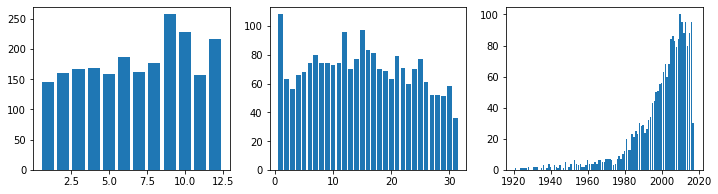

In [111]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1).bar(train_data.release_month.value_counts().index,train_data.release_month.value_counts().values)
plt.subplot(1, 3, 2).bar(train_data.release_day.value_counts().index,train_data.release_day.value_counts().values)
plt.subplot(1, 3, 3).bar(train_data.release_year.value_counts().index,train_data.release_year.value_counts().values)


In [112]:
train_data.drop(columns='release_date', inplace=True)

In [113]:
train_data.head(1)

,budget,popularity,runtime,revenue,belongs_to_a_collection,homepage_is_present,genre_Thriller,genre_History,genre_Science Fiction,genre_Drama,genre_Mystery,genre_Western,genre_Action,genre_Music,genre_Animation,genre_Documentary,genre_Family,genre_Adventure,genre_Crime,genre_War,genre_Romance,genre_Horror,genre_Foreign,genre_Fantasy,genre_TV Movie,genre_Comedy,Keywords (duringcreditsstinger),Keywords (woman director),Keywords (murder),Keywords (independent film),Keywords (based on novel),Keywords (violence),Keywords (dystopia),Keywords (aftercreditsstinger),Keywords (sport),Keywords (revenge),Keywords (biography),Keywords (sequel),Keywords (suspense),Keywords (friendship),...,crew (Billy Wilder),crew (Eric Fellner),crew (Ve Neill),crew (Sylvester Stallone),crew (Ron Howard),crew (Debra Zane),crew (Robert Zemeckis),crew (Bill Corso),crew (Michael Mann),crew (Brian Grazer),crew (Ridley Scott),crew (Louise Frogley),crew (Mike Fenton),crew (John Lasseter),crew (Ryan Kavanaugh),crew (Stan Lee),crew (Randall Poster),crew (Lucinda Syson),crew (Suzanne Smith),crew (Toby Emmerich),crew (John Ottman),crew (Ian Fleming),crew (Howard Shore),crew (David B. Nowell),crew (Harold Ramis),crew (Sam Raimi),crew (Brian Tyler),crew (Carter Burwell),crew (Nina Gold),crew (Todd Phillips),crew (Robert Elswit),crew (Gale Anne Hurd),crew (Trevor Rabin),crew (Jim Passon),crew (Alfred Hitchcock),crew (Woody Allen),crew (Pete Anthony),release_month,release_day,release_year
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,16.454568,6.575393,93.0,16.3263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,20,2015


In [114]:
train_data.runtime.isnull().sum()

1

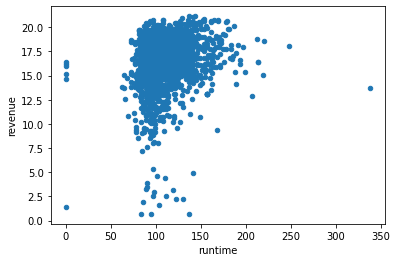

In [115]:
train_data.plot.scatter("runtime", "revenue")

# Addestramento


In [116]:
train_data.dropna(inplace=True)

In [117]:
train_data.isna().sum()

budget                     0
popularity                 0
runtime                    0
revenue                    0
belongs_to_a_collection    0
                          ..
crew (Woody Allen)         0
crew (Pete Anthony)        0
release_month              0
release_day                0
release_year               0
Length: 493, dtype: int64

In [118]:
y_data = train_data.revenue
train_data.drop(columns='revenue', inplace=True)

In [119]:
X = train_data

In [120]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

In [121]:
# importo MSE e R²
from sklearn.metrics import mean_squared_error, r2_score

# definisco funzione per errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# funzione per calcolare e stampare tutte e tre
def print_eval(X, y, model):
    preds = model.predict(X)
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("       Relative error: {:.5%}".format(relative_error(y, preds)))
    print("R-squared coefficient: {:.5}".format(r2_score(y, preds)))

In [122]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True, random_state=42)
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=2, kernel="poly", degree=2))
])
from sklearn.model_selection import cross_validate
cv_result = cross_validate(model, X, y_data, cv=kf, return_train_score=True)
cv_result

{'fit_time': array([0.20287776, 0.21261096, 0.20263886, 0.20207286, 0.19591808]),
 'score_time': array([0.02265   , 0.02264047, 0.03095627, 0.0374732 , 0.02157879]),
 'test_score': array([0.44887298, 0.48725953, 0.40669712, 0.41393431, 0.44650964]),
 'train_score': array([0.70409562, 0.70275326, 0.70912286, 0.69937676, 0.70258695])}

In [123]:
outer_cv = KFold(3, shuffle=True, random_state=42)
inner_cv = KFold(5, shuffle=True, random_state=42)


In [124]:
def nested_cv(model, grid):
    results = []
    for train_indices, val_indices in outer_cv.split(train_data, y_data):
        X_train, y_train = train_data.iloc[train_indices], y_data.iloc[train_indices]
        X_val, y_val = train_data.iloc[val_indices], y_data.iloc[val_indices]
        gs = GridSearchCV(model, grid, cv=inner_cv)
        gs.fit(X_train, y_train)
        score = gs.score(X_val, y_val)
        results.append(score)
    return results

model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", KernelRidge(kernel="poly"))
])
grid = {
    "regr__degree": range(2, 11),
    "regr__alpha": [0.01, 0.1, 1, 10],
}
nested_cv(model, grid)

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
    train_test_split(X, y_data, test_size=1/3, random_state=42)

In [126]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=2, kernel="poly", degree=2))
])
model.fit(X_train, y_train);

In [127]:
model.score(X_train, y_train)

0.7126410707747335

In [128]:
print_eval(X_train, y_train, model)

   Mean squared error: 1.7052
       Relative error: 7.71830%
R-squared coefficient: 0.71264


In [129]:
print_eval(X_val, y_val, model)

   Mean squared error: 4.4447
       Relative error: 15.74968%
R-squared coefficient: 0.44057


In [130]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=6, random_state=42)
model.fit(X_train, y_train);

In [131]:
model.score(X_train, y_train)

0.6568870433208016

In [132]:
print_eval(X_train, y_train, model)

   Mean squared error: 2.036
       Relative error: 7.03280%
R-squared coefficient: 0.65689


In [133]:
print_eval(X_val, y_val, model)

   Mean squared error: 4.7022
       Relative error: 15.83869%
R-squared coefficient: 0.40815


In [134]:
model.score(X_val, y_val)

0.4081534920083768

In [135]:
model = DecisionTreeRegressor(min_samples_split=0.4, random_state=42)
model.fit(X_train, y_train);

In [136]:
model.score(X_train, y_train)

0.34883649953275

In [137]:
model.score(X_val, y_val)

0.2637324896287204

In [138]:
model = DecisionTreeRegressor(random_state=42)
grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 0.02, 0.05, 0.1]
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 5, 'min_samples_split': 0.05}

In [139]:
gs.score(X_val, y_val)

0.38361073339638585

In [140]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(
    hidden_layer_sizes=[4],
    activation="relu",
    solver="sgd",
    random_state=12345
)

In [141]:
model.fit(X_train, y_train);

In [142]:
model.score(X_val, y_val)

-0.006939840942005614

In [143]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [144]:
model = Sequential([
    Dense(128, activation="relu", input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [145]:
model.fit(X_train, y_train, batch_size=100, epochs=5)


Epoch 1/5
15/15 [==============================] - 0s 3ms/step - loss: 2406.9568
Epoch 2/5
15/15 [==============================] - 0s 3ms/step - loss: 274.1786
Epoch 3/5
15/15 [==============================] - 0s 2ms/step - loss: 58.7758
Epoch 4/5
15/15 [==============================] - 0s 2ms/step - loss: 21.6905
Epoch 5/5
15/15 [==============================] - 0s 2ms/step - loss: 11.5633


In [146]:
model = Sequential([
    Dense(512, activation="relu", input_dim=X_train.shape[1]),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [147]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
15/15 [==============================] - 0s 3ms/step - loss: 401.0649
Epoch 2/5
15/15 [==============================] - 0s 2ms/step - loss: 16.3866
Epoch 3/5
15/15 [==============================] - 0s 3ms/step - loss: 5.6441
Epoch 4/5
15/15 [==============================] - 0s 2ms/step - loss: 5.2992
Epoch 5/5
15/15 [==============================] - 0s 2ms/step - loss: 5.2183


In [148]:
from tensorflow.keras.regularizers import l2
model = Sequential([
    Dense(128, activation="relu", kernel_regularizer=l2(0.001), input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")

In [149]:
model.fit(X_train, y_train, batch_size=100, epochs=50)

Epoch 1/50
15/15 [==============================] - 0s 2ms/step - loss: 5889.5957
Epoch 2/50
15/15 [==============================] - 0s 2ms/step - loss: 885.9078
Epoch 3/50
15/15 [==============================] - 0s 2ms/step - loss: 171.8855
Epoch 4/50
15/15 [==============================] - 0s 2ms/step - loss: 30.8518
Epoch 5/50
15/15 [==============================] - 0s 2ms/step - loss: 7.9313
Epoch 6/50
15/15 [==============================] - 0s 2ms/step - loss: 5.2348
Epoch 7/50
15/15 [==============================] - 0s 2ms/step - loss: 5.0510
Epoch 8/50
15/15 [==============================] - 0s 2ms/step - loss: 4.8695
Epoch 9/50
15/15 [==============================] - 0s 2ms/step - loss: 4.8216
Epoch 10/50
15/15 [==============================] - 0s 2ms/step - loss: 4.7766
Epoch 11/50
15/15 [==============================] - 0s 2ms/step - loss: 4.5979
Epoch 12/50
15/15 [==============================] - 0s 2ms/step - loss: 4.2996
Epoch 13/50
15/15 [======================

In [150]:
X_train.head(1)

,budget,popularity,runtime,belongs_to_a_collection,homepage_is_present,genre_Thriller,genre_History,genre_Science Fiction,genre_Drama,genre_Mystery,genre_Western,genre_Action,genre_Music,genre_Animation,genre_Documentary,genre_Family,genre_Adventure,genre_Crime,genre_War,genre_Romance,genre_Horror,genre_Foreign,genre_Fantasy,genre_TV Movie,genre_Comedy,Keywords (duringcreditsstinger),Keywords (woman director),Keywords (murder),Keywords (independent film),Keywords (based on novel),Keywords (violence),Keywords (dystopia),Keywords (aftercreditsstinger),Keywords (sport),Keywords (revenge),Keywords (biography),Keywords (sequel),Keywords (suspense),Keywords (friendship),Keywords (police),...,crew (Billy Wilder),crew (Eric Fellner),crew (Ve Neill),crew (Sylvester Stallone),crew (Ron Howard),crew (Debra Zane),crew (Robert Zemeckis),crew (Bill Corso),crew (Michael Mann),crew (Brian Grazer),crew (Ridley Scott),crew (Louise Frogley),crew (Mike Fenton),crew (John Lasseter),crew (Ryan Kavanaugh),crew (Stan Lee),crew (Randall Poster),crew (Lucinda Syson),crew (Suzanne Smith),crew (Toby Emmerich),crew (John Ottman),crew (Ian Fleming),crew (Howard Shore),crew (David B. Nowell),crew (Harold Ramis),crew (Sam Raimi),crew (Brian Tyler),crew (Carter Burwell),crew (Nina Gold),crew (Todd Phillips),crew (Robert Elswit),crew (Gale Anne Hurd),crew (Trevor Rabin),crew (Jim Passon),crew (Alfred Hitchcock),crew (Woody Allen),crew (Pete Anthony),release_month,release_day,release_year
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1705,17.55318,10.174298,100.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,11,2011
